In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_4', 'denoised'), ('TS_5_4', 'denoised'), ('TS_21', 'denoised'), ('TS_3', 'denoised'), ('TS_1', 'denoised'), ('TS_73_6', 'denoised'), ('TS_7', 'denoised'), ('TS_19', 'denoised'), ('TS_5', 'denoised'), ('TS_23', 'denoised'), ('TS_12', 'denoised'), ('TS_26', 'denoised'), ('TS_8', 'denoised'), ('TS_99_9', 'denoised'), ('TS_20', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised'), ('TS_17', 'denoised'), ('TS_0', 'denoised'), ('TS_16', 'denoised'), ('TS_2', 'denoised'), ('TS_10', 'denoised'), ('TS_25', 'denoised'), ('TS_24', 'denoised'), ('TS_22', 'denoised'), ('TS_6', 'denoised'), ('TS_9', 'denoised'), ('TS_15', 'denoised'), ('TS_18', 'denoised'), ('TS_13', 'denoised'), ('TS_14', 'denoised'), ('TS_11', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/32 [00:00<?, ?it/s]


100

In [3]:
import torch
import torchvision.transforms.functional as F
import random

Valid-Epoch: 0, Loss: 0.5308301886948554:  92%|█████████▏| 184/200 [00:08<00:00, 20.87it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 0, VALID_SCORE: 0.1632794441558454


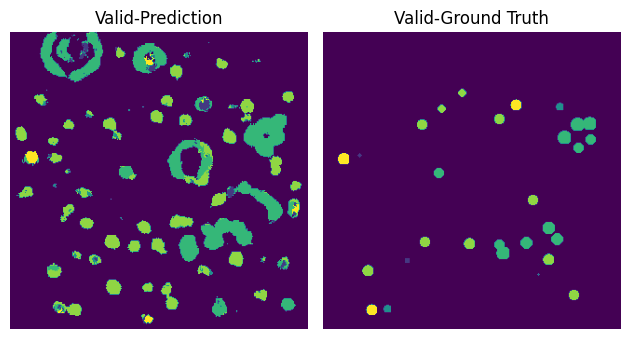

Valid-Epoch: 1, Loss: 0.362874965628852:  92%|█████████▏| 184/200 [00:08<00:00, 22.65it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 1, VALID_SCORE: 0.010856817065187842


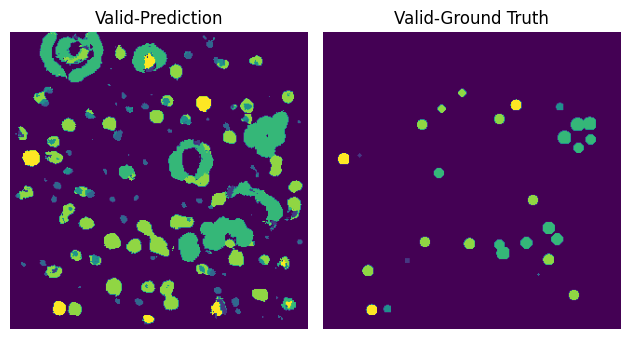

Valid-Epoch: 2, Loss: 0.5936855993375344:  92%|█████████▏| 184/200 [00:08<00:00, 21.92it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 2, VALID_SCORE: 0.014530138053607453


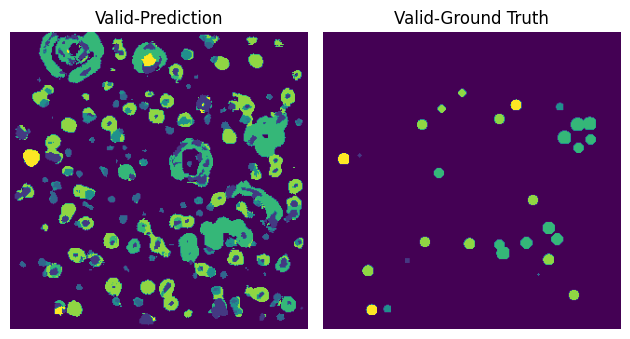

Train-Epoch: 3, Loss: 0.5281718190227236:   4%|▍         | 35/800 [00:08<02:29,  5.12it/s]

In [ ]:
model = UNet_2D().to("cuda")
model.eval()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_score = 0
batch_size = 4

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = defaultdict(list)
    train_gt_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            from_, to_ = 0, tomogram.shape[1]
            random_index = random.sample(range(from_, to_), batch_size)
            input_ = tomogram[:, random_index]
            input_ = input_.permute(1, 0, 2, 3)  # (batch_size, 1, 160, 160)
            gt = segmentation_map[:, random_index].squeeze()  # (batch_size, 160, 160)

            input_, gt = aug(input_, gt)

            input_ = input_.to("cuda")
            gt = gt.to("cuda")
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            for i in range(batch_size):
                train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
                train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    valid_score_ = visualize_epoch_results(
        valid_pred_tomogram,
        valid_gt_tomogram,
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}")

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 可視化
    index = 50

    # plt.figure(figsize=(10, 5))

    # ax = plt.subplot(1, 4, 1)
    # ax.imshow(train_pred_tomogram[exp_name][index].argmax(0))
    # ax.set_title("Train-Prediction")
    # ax.axis("off")

    # ax = plt.subplot(1, 4, 2)
    # ax.imshow(train_gt_tomogram[exp_name][index])
    # ax.set_title("Train-Ground Truth")
    # ax.axis("off")

    ax = plt.subplot(1, 2, 1)
    ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 2, 2)
    ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.tight_layout()

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

In [ ]:
# 可視化
index = 50

plt.figure(figsize=(10, 5))

# ax = plt.subplot(1, 4, 1)
# ax.imshow(train_pred_tomogram[exp_name][index].argmax(0))
# ax.set_title("Train-Prediction")
# ax.axis("off")

# ax = plt.subplot(1, 4, 2)
# ax.imshow(train_gt_tomogram[exp_name][index])
# ax.set_title("Train-Ground Truth")
# ax.axis("off")

ax = plt.subplot(1, 2, 1)
ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
ax.set_title("Valid-Prediction")
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
ax.set_title("Valid-Ground Truth")
ax.axis("off")

plt.tight_layout()

plt.show()